<a href="https://colab.research.google.com/github/prog815/portfOptim/blob/master/%D0%9E%D0%B3%D1%80%D0%B0%D0%BD%D0%B8%D1%87%D0%B5%D0%BD%D0%B8%D0%B5_%D0%BF%D0%B0%D0%B4%D0%B5%D0%BD%D0%B8%D0%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Загрузка библиотек

In [1]:
! pip install bt
! pip install git+https://github.com/prog815/progGA

     |████████████████████████████████| 2.7MB 6.2MB/s 
  Created wheel for bt: filename=bt-0.2.7-cp36-cp36m-linux_x86_64.whl size=533280 sha256=a7c41aef05dbf0f299fefc4b0142c6d4104687c019073690482d41689944ea59
  Stored in directory: /root/.cache/pip/wheels/ae/8a/a2/a679757e4e7219e6f17727d1422d4ce32da847678c6559da35
  Created wheel for ffn: filename=ffn-0.3.4-cp36-none-any.whl size=22813 sha256=b3c8506c58433ba4c3c57b7ac4ae62cb6e821faf5fae7be6c1c5896ad64f04fa
  Stored in directory: /root/.cache/pip/wheels/20/08/4d/921180e81279d147cb6399fe1e194f2c67a796df86f9f4c5fe
Successfully built bt ffn
  Cloning https://github.com/prog815/progGA to /tmp/pip-req-build-uyyc4hd5
  Running command git clone -q https://github.com/prog815/progGA /tmp/pip-req-build-uyyc4hd5
  Created wheel for progGA: filename=progGA-0.0.7-cp36-none-any.whl size=3733 sha256=48f337490b851b6b4e57a7abc322ea84f5dcdd36bc62f09a41c43595eba61515
  Stored in directory: /tmp/pip-ephem-wheel-cache-icbgcs2o/wheels/9c/7a/cc/d1ffa9ccaa42b

In [2]:
import bt
from progGA import ListGenetic
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings

fn = '/content/drive/My Drive/prog/model_limDn_29.10.2020.pkl'

/usr/local/lib/python3.6/dist-packages/ffn/core.py:27: MatplotlibDeprecationWarning: The 'warn' parameter of use() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'warn', they should be pass as keyword, not positionally.
  matplotlib.use('agg', warn=False)


# Загрузка истории

In [3]:
data = bt.get('AAPL,AAL,GE,F',start='2010-01-01')
lenData = len(data)
data

,aapl,aal,ge,f
Date,,,,
2010-01-04,6.604801,4.496876,10.840267,6.937616
2010-01-05,6.616219,5.005957,10.896401,7.396526
2010-01-06,6.510980,4.798555,10.840267,7.673220
2010-01-07,6.498945,4.939965,11.401575,7.868933
2010-01-08,6.542150,4.845690,11.647147,7.889179
...,...,...,...,...
2020-10-26,115.050003,11.800000,7.380000,8.030000
2020-10-27,116.599998,11.230000,7.100000,7.920000
2020-10-28,111.199997,10.950000,7.420000,7.700000


# Алгоритм распределения

In [4]:
def predWeights(d,lookback=10,lag=10,learnLen=300,reg = 0.0001,min_delta = 0.001,lr=0.0001,hl=100,doRate=0.5):

    n = d.shape[1]
    
    X = pd.concat([d.shift(lag+n) for n in range(1,lookback+1)],axis=1)
    y = d.rolling(lag).mean().shift(1-lag)
    xy = pd.concat([y,X],axis=1).dropna()
    y = xy.iloc[-learnLen:,:n]
    X = xy.iloc[-learnLen:,n:]
    
    def loss_function(y_true, y_pred):
        return tf.nn.relu(tf.math.reduce_mean(y_true,axis=1))-tf.math.reduce_sum(y_true * y_pred[:,:-1],axis=1)

    model = keras.Sequential([layers.Dense(hl,activation='sigmoid',input_shape=(X.shape[1],),kernel_regularizer=keras.regularizers.l2(reg)),
                              layers.Dropout(doRate),
                              layers.Dense(n+1,activation='softmax',kernel_regularizer=keras.regularizers.l2(reg))
                              ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),loss=loss_function)
    #help(model.fit)
    
    # print('------------------')
    # print('d',d.shape)
    # print('lookback=',lookback)
    # print('lag=',lag)
    # print('learnLen=',learnLen)
    # print('reg=',reg)
    # print('min_delta=',min_delta)
    # print('lr=',lr)
    # print('hl=',hl)
    # print('doRate=',doRate)
    # print('X',X.shape)
    # print('y',y.shape)

    learn_res = model.fit(X, y, epochs=1000,validation_split=0.2,verbose=False,use_multiprocessing=True,callbacks=[keras.callbacks.EarlyStopping('val_loss',min_delta=min_delta,patience=10)])
    
    X = pd.concat([d.shift(n) for n in range(0,lookback)],axis=1)
    weights = model.predict(X)[-1,:-1]

    return weights

dData = data.to_returns()
#t = np.random.randint(2*lag+learnLen+lookback+1,lenData-1-2*lag)
t=1000

for n in range(10):
    weights = predWeights(dData[:t])
    print(weights,1-sum(weights))


[0.03829718 0.14438497 0.13138917 0.44580317] 0.24012551456689835
[0.2463203  0.15682651 0.42119592 0.09076907] 0.08488818258047104
[0.14933456 0.09561264 0.21642452 0.49123   ] 0.04739826172590256
[0.2122695  0.28433776 0.14086567 0.2120709 ] 0.15045617520809174
[0.03127501 0.28914294 0.09506618 0.3411276 ] 0.24338826909661293
[0.09854709 0.48836502 0.08436444 0.21901587] 0.10970758646726608
[0.10770299 0.22851533 0.21105514 0.31284544] 0.13988110423088074
[0.09695686 0.15538256 0.33980587 0.3021082 ] 0.10574650764465332
[0.13962127 0.37729278 0.11791316 0.23465101] 0.1305217668414116
[0.17049024 0.34409228 0.11384268 0.1807974 ] 0.19077740609645844


In [5]:
class WeighPredTF(bt.Algo):
    def __init__(self, lookback, learnLen, reg, min_delta, lr, hl, lag, doRate):
        super(WeighPredTF, self).__init__()

        self.lookback = lookback
        self.learnLen = learnLen
        self.reg = reg
        self.min_delta = min_delta
        self.lr = lr
        self.hl = hl
        self.lag = lag
        self.doRate = doRate

    def __call__(self, target):
        
        selected = target.temp['selected']
        n = len(selected)

        if n == 0:
            target.temp['weights'] = {}
        else:
            w = 1.0 / n
            target.temp['weights'] = {x: w for x in selected}
        
        d = target.universe[selected].to_returns()
        
        weights = predWeights(d,
                              lookback=self.lookback,
                              lag=self.lag,
                              learnLen=self.learnLen,
                              reg=np.power(10,self.reg),
                              min_delta=np.power(10,self.min_delta),
                              lr=np.power(10,self.lr),
                              hl=self.hl,
                              doRate=self.doRate)

        target.temp['weights'] = pd.Series({d.columns[i]: weights[i] for i in range(n)}).dropna()
        
        return True

# Поиск гиперпараметров

## Целевая функция

In [6]:
def getQualityMethod(lookback,learnLen,reg,min_delta,lr,hl,lag,doRate):

    t = np.random.randint(2*lag+learnLen+lookback+1,lenData-1-2*lag)
    #print('t=',t)
    
    weights = predWeights(dData[:t],
                          lookback=lookback,
                          lag=lag,
                          learnLen=learnLen,
                          reg=np.power(10,reg),
                          min_delta=np.power(10,min_delta),
                          lr=np.power(10,lr),
                          hl=hl,
                          doRate=doRate)
    # print(weights)

    d = dData[t:(t+lag)]                # данные
    
    p = sum(d.mean().values*weights)    # на прогнозе среднее
    m = d.values.mean()                 # на курсах среднее
    v = abs(d.values).mean()            # на модулях изменений среднее
    
    # raise Exception()

    return (p-m)/v

## Создание модели

In [7]:
modelGA = ListGenetic(pop_size=200,
                      lookback=range(30,200),
                      learnLen=range(50,500),
                      reg=np.arange(-7.0,-0.5,0.01),
                      min_delta=np.arange(-7.0,-0.5,0.01),
                      lr=np.arange(-7.0,-0.1,0.01),
                      hl=range(10,1000),
                      lag=range(1,200),
                      doRate=np.arange(0.01,1.0,0.01),
                      quality_method=getQualityMethod)

if os.path.exists(fn):
    with open(fn,'rb') as fp:
        modelGA = pickle.load(fp)

## Бесконечный цикл поиска

In [ ]:
import logging
logging.getLogger('tensorflow').disabled = True

while True:
    modelGA.fit(10,echo_time=60)
    with open(fn,'wb') as fp:
        pickle.dump(modelGA,fp)

finish -  212 {'quality': 0.03691121724092863, 'lookback': 114, 'learnLen': 117, 'reg': -3.2200000000000806, 'min_delta': -4.390000000000056, 'lr': -1.600000000000115, 'hl': 887, 'lag': 78, 'doRate': 0.09999999999999999}
finish -  222 {'quality': -0.03334922075474916, 'lookback': 124, 'learnLen': 335, 'reg': -6.230000000000016, 'min_delta': -5.830000000000025, 'lr': -3.210000000000081, 'hl': 59, 'lag': 149, 'doRate': 0.12}
228 {'quality': -0.049040072683110364, 'lookback': 151, 'learnLen': 120, 'reg': -2.820000000000089, 'min_delta': -6.05000000000002, 'lr': -4.0200000000000635, 'hl': 670, 'lag': 124, 'doRate': 0.46}
finish -  232 {'quality': 0.11926639883518217, 'lookback': 162, 'learnLen': 110, 'reg': -6.120000000000019, 'min_delta': -2.1800000000001027, 'lr': -3.3100000000000787, 'hl': 315, 'lag': 31, 'doRate': 0.66}
finish -  242 {'quality': 0.048162897435745325, 'lookback': 138, 'learnLen': 190, 'reg': -4.2100000000000595, 'min_delta': -4.260000000000058, 'lr': -4.3500000000000565

## Графики

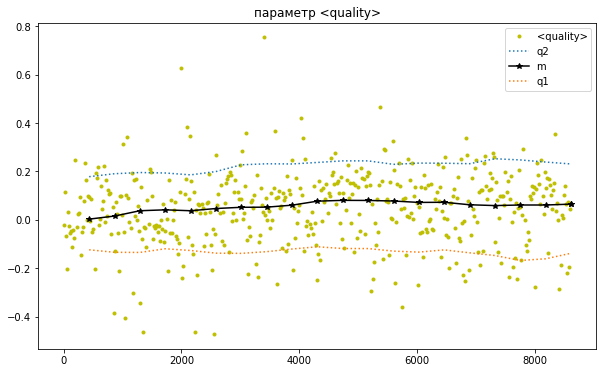

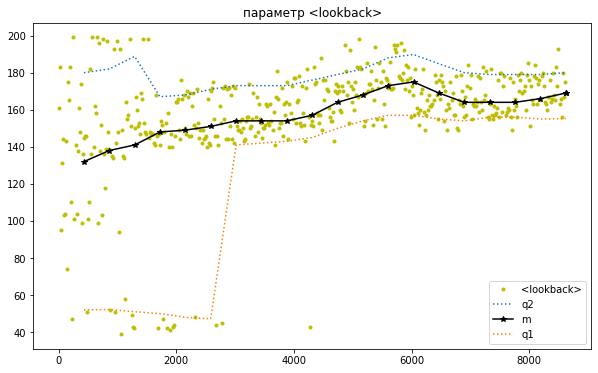

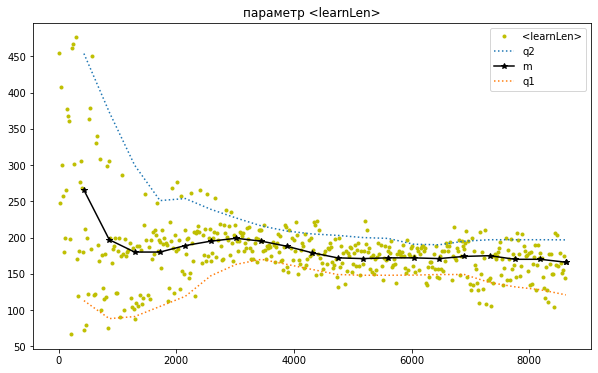

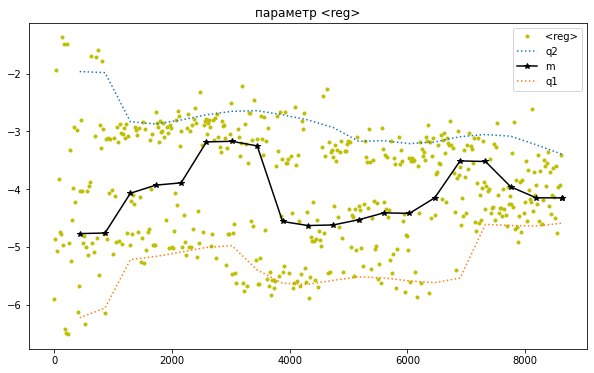

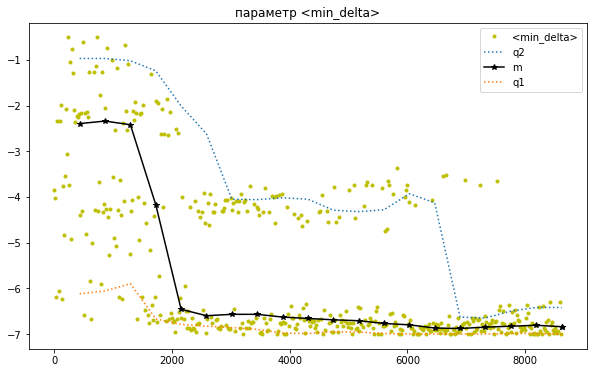

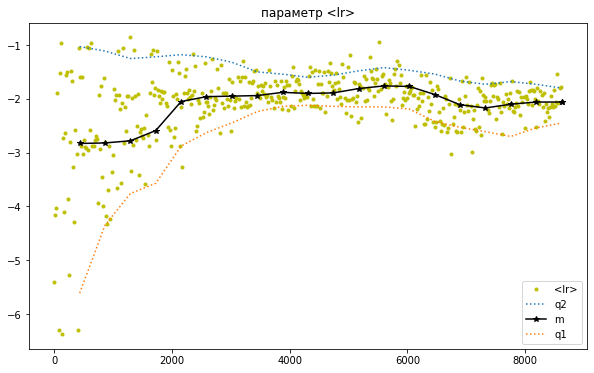

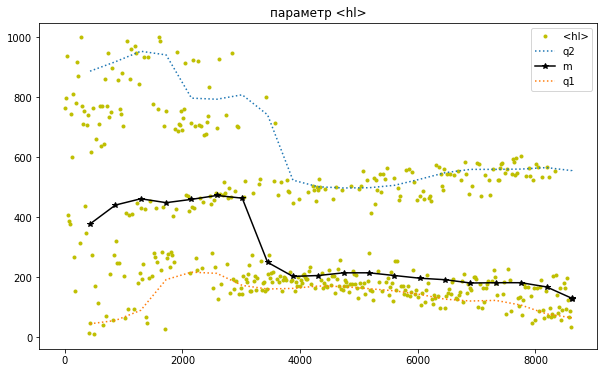

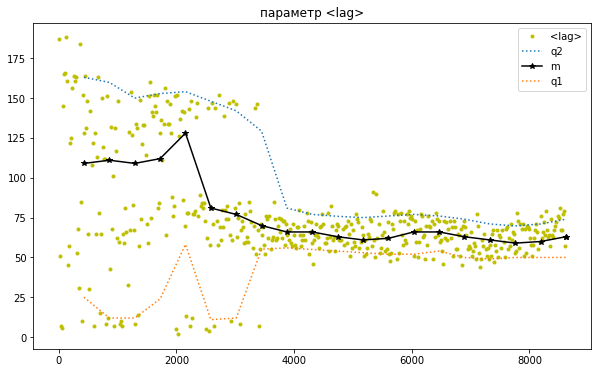

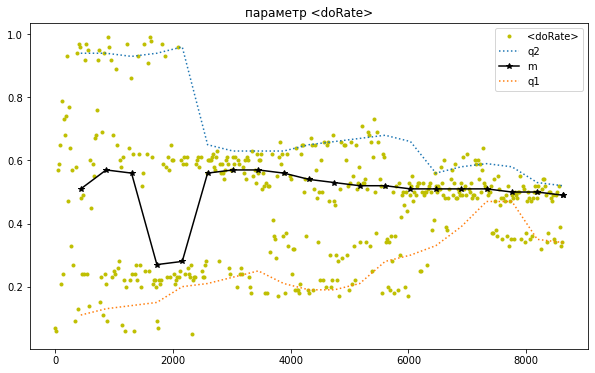

In [8]:
modelGA.plot_hist_new(('quality','lookback','learnLen','reg','min_delta','lr','hl','lag','doRate'))


## Параметры лучшей

In [9]:
best_par = modelGA.getBestParams()
best_par

{'doRate': 0.43,
 'hl': 133,
 'lag': 64,
 'learnLen': 154,
 'lookback': 171,
 'lr': -2.070000000000105,
 'min_delta': -6.800000000000004,
 'reg': -4.040000000000063}

# Прогон лучшей

In [10]:
lookback_best = best_par['lookback']
lag_best = best_par['lag']
learnLen_best = best_par['learnLen']
reg_best = best_par['reg']
min_delta_best = best_par['min_delta']
lr_best = best_par['lr']
hl_best = best_par['hl']
doRate_best = best_par['doRate']

s_best = bt.Strategy('лучший', [bt.algos.RunEveryNPeriods(lag_best,offset=lag_best*2+learnLen_best+lookback_best+1),
                                bt.algos.SelectAll(),
                                WeighPredTF(lookback=lookback_best,
                                            learnLen=learnLen_best,
                                            reg=reg_best,
                                            min_delta=min_delta_best,
                                            lr=lr_best,
                                            hl=hl_best,
                                            lag=lag_best,
                                            doRate=doRate_best),
                                bt.algos.Rebalance()])
test_best = bt.Backtest(s_best, data)

s0 = bt.Strategy('равновесный', [bt.algos.RunEveryNPeriods(lag_best,offset=lag_best+learnLen_best+lookback_best+1),
                                 bt.algos.SelectAll(),
                                 bt.algos.WeighEqually(),
                                 bt.algos.Rebalance()])
test0 = bt.Backtest(s0, data)

res_best = bt.run(test_best,test0)

лучший
0% [############################# ] 100% | ETA: 00:00:09равновесный
0% [############################# ] 100% | ETA: 00:00:00

## График баланса

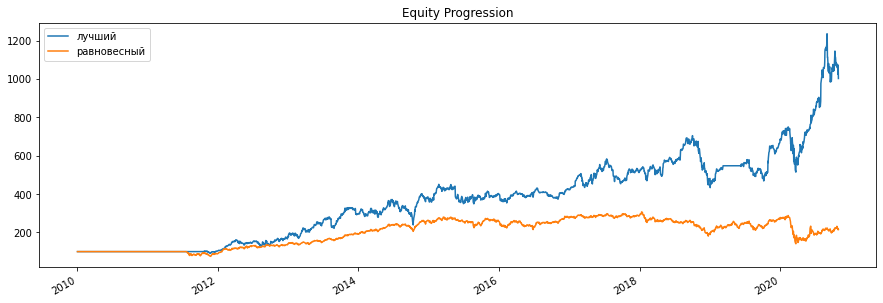

In [11]:
res_best.plot()

## график распределения долей

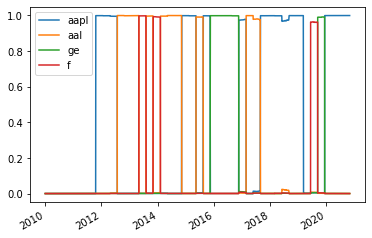

In [12]:
res_best.get_security_weights().plot()

## график распределения свободной доли

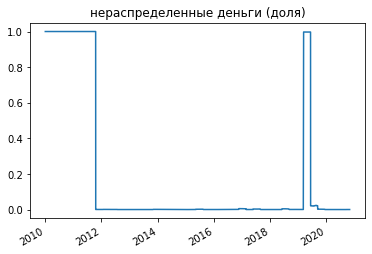

In [13]:
w = res_best.get_weights(0)
w['деньги'] = 1-w.values[:,1:].sum(axis=1)
w['деньги'].plot()
plt.title('нераспределенные деньги (доля)')
del(w)

## итог

In [14]:
res_best.display()

Stat                 лучший      равновесный
-------------------  ----------  -------------
Start                2010-01-03  2010-01-03
End                  2020-10-30  2020-10-30
Risk-free rate       0.00%       0.00%

Total Return         902.12%     115.11%
Daily Sharpe         0.87        0.41
Daily Sortino        1.43        0.65
CAGR                 23.73%      7.33%
Max Drawdown         -38.50%     -54.19%
Calmar Ratio         0.62        0.14

MTD                  -6.00%      5.11%
3m                   13.37%      12.05%
6m                   48.85%      25.43%
YTD                  49.24%      -20.34%
1Y                   75.55%      -13.12%
3Y (ann.)            25.87%      -8.73%
5Y (ann.)            19.89%      -4.37%
10Y (ann.)           25.93%      7.96%
Since Incep. (ann.)  23.73%      7.33%

Daily Sharpe         0.87        0.41
Daily Sortino        1.43        0.65
Daily Mean (ann.)    25.58%      10.03%
Daily Vol (ann.)     29.25%      24.32%
Daily Skew           0.05   

Енин А.В.

Оренбург